# Описание

**Файд содержит три блока:**

1. Конвертация DESCRIPTION/.JSON
2. Алгоритм поиска ближайших заведений
3. Написание бота

Каждый из блоков, при наличие данных запускается отдельно. 

**P.S.** Для запуска бота достаточно блока "*Написание бота*". Нужно вставить **свой API ключ** (Получить его можно написав *BotFather*).

**P.S.S.** Для запуска блока "*Алгоритм поиска ближайших заведений*", необходимо запустить yandex_geocoder из "*Конвертация DESCRIPTION/.JSON*", предварительно вставив **свой API Yandex Map ключ**.

# Конвертация DESCRIPTION/.JSON


In [4]:
!unzip /content/spb-20200707T175500Z-001.zip

Archive:  /content/spb-20200707T175500Z-001.zip
  inflating: spb/description/spb_market.json  
  inflating: spb/description/spb_bars_and_clubs.json  
  inflating: spb/description/spb_fast_snacks.json  
  inflating: spb/description/spb_deserts.json  
  inflating: spb/reviews/spb_market_reviews.json  
  inflating: spb/description/spb_bakery.json  
  inflating: spb/description/spb_coffee_and_tea.json  
  inflating: spb/reviews/spb_coffee_and_tea_reviews.json  
  inflating: spb/reviews/spb_deserts_reviews.json  
  inflating: spb/reviews/spb_bars_and_clubs_reviews.json  
  inflating: spb/reviews/spb_fast_snacks_reviews.json  
  inflating: spb/reviews/spb_bakery_reviews.json  
  inflating: spb/description/spb_restaurants.json  
  inflating: spb/reviews/spb_restaurants_reviews.json  


Подключаем библиотеки

In [2]:
import pandas as pd
import numpy as np

Импорт данных.

**P.S.** Данные о барах и клубах Санкт-Петербурга с *tripadvisor.ru*



In [5]:
data = pd.read_json('/content/spb/description/spb_bars_and_clubs.json', lines=True)
data.head()

,name,address,schedule_start,schedule_start_letter,schedule_end,schedule_end_letter,average_rating,number_of_reviews,place_in_rating,award_text,years_text,feature_1_name,feature_1,feature_2_name,feature_2,feature_3_name,feature_3,distance_from,photo1,photo2,photo3,photo4,ctime,curl
0,Рок Паб,"Проспект Пятилеток 8, Санкт-Петербург 193318 Р...",None,None,None,None,"4,0",9 отзывов,№ 284 из 410 – Американская – Санкт-Петербург,None,None,ДИАПАЗОН ЦЕН,300 руб - 1 900 руб,ТИП КУХНИ,"Американская, Бар, Паб, Гастропаб",УСЛУГИ,Бронирование,None,None,None,None,None,1591711288,https://www.tripadvisor.ru/Restaurant_Review-g...
1,Ни В Одном Глазу,"переулок Ульяны Громовой, 4, Санкт-Петербург 1...",4:00,PM,02:00,AM,"5,0",1 отзыв,№ 150 из 174 – Средиземноморская – Санкт-Петер...,None,None,ТИП КУХНИ,"Средиземноморская, Европейская, Гриль, Совреме...",ВРЕМЯ ПРИЕМА ПИЩИ,Ужин,None,None,"0,4 км от: Невский проспект","data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...","data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...","data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...","data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",1591711288,https://www.tripadvisor.ru/Restaurant_Review-g...
2,Gypsies & Jews,"Ломоносова, 14, Санкт-Петербург 191002 Россия",None,None,None,None,"5,0",1 отзыв,№ 506 из 677 – Бар – Санкт-Петербург,None,None,ТИП КУХНИ,"Бар, Паб, Закусочная, Уличная еда",None,None,None,None,None,None,None,None,None,1591711288,https://www.tripadvisor.ru/Restaurant_Review-g...
3,Blackberry,"Гражданский проспект, 41 лит Б, Санкт-Петербур...",None,None,None,None,"4,0",5 отзывов,№ 4 140 из 6 851 – Рестораны – Санкт-Петербург,None,None,ТИП КУХНИ,"Бар, Паб",None,None,None,None,None,"data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",None,None,None,1591711288,https://www.tripadvisor.ru/Restaurant_Review-g...
4,Bazin,"Некрасова, 22, Санкт-Петербург 191014 Россия",None,None,None,None,"5,0",1 отзыв,№ 509 из 677 – Бар – Санкт-Петербург,None,None,ТИП КУХНИ,"Бар, Паб",None,None,None,None,None,"data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",None,None,None,1591711288,https://www.tripadvisor.ru/Restaurant_Review-g...


**Поработаем с данными.**

Столбец place_in_rating, является отношением "Позиция бара в рейтинге" / "Колличество баров в рейтинге". Если отношение стремится к 0, тогда рейтинг бара стремится к первой строчки рейтинга.

**P.S.** Если place_in_rating = 0, тогда этот бар не был в рейтинге.

In [6]:
place_in_rating = data['place_in_rating'].str.split(' ',expand=True)

In [7]:
place_in_rating = place_in_rating.apply(lambda x: pd.to_numeric(x,errors='coerce')).drop(columns=[0,2,4,5,6,7,8,9])

In [8]:
place_in_rating['place_in_rating'] = place_in_rating[1]/place_in_rating[3]

In [9]:
place_in_rating = place_in_rating.drop(columns=[1,3])
place_in_rating.fillna(0, inplace=True)

Столбец average_rating - средняя оценка бара, от пользователей.

**P.S.** Если average_rating = 0, тогда этот бар еще не был оценен.

In [10]:
average_rating	= data['average_rating']
average_rating.fillna(0, inplace=True)

Оставляем необходимые столбцы.

In [11]:
data['place_in_rating'] = place_in_rating
data['average_rating'] = average_rating

In [12]:
data = data[['name',	'address','place_in_rating','average_rating','curl']]

In [13]:
data.head()

,name,address,place_in_rating,average_rating,curl
0,Рок Паб,"Проспект Пятилеток 8, Санкт-Петербург 193318 Р...",0.692683,"4,0",https://www.tripadvisor.ru/Restaurant_Review-g...
1,Ни В Одном Глазу,"переулок Ульяны Громовой, 4, Санкт-Петербург 1...",0.862069,"5,0",https://www.tripadvisor.ru/Restaurant_Review-g...
2,Gypsies & Jews,"Ломоносова, 14, Санкт-Петербург 191002 Россия",0.747415,"5,0",https://www.tripadvisor.ru/Restaurant_Review-g...
3,Blackberry,"Гражданский проспект, 41 лит Б, Санкт-Петербур...",0.000000,"4,0",https://www.tripadvisor.ru/Restaurant_Review-g...
4,Bazin,"Некрасова, 22, Санкт-Петербург 191014 Россия",0.751846,"5,0",https://www.tripadvisor.ru/Restaurant_Review-g...


In [14]:
data.to_csv('data.csv',index=False)

**Получим координаты широты и долготы по адресам баров.** 

В качестве геокодера, рассматривался Nominatim, Google Map, Yandex Map.

**Геокодер Nominatim**, не требует API, но при этом плохо работает с адресами на кириллице. Из 208 строк адресов, 64 адреса не выявлено (None). Колличество остаточных данных = 69,23%.

**Геокодер Yandex Map**, требует API, но при этом лучший геокодер для кириллицы среди остальных. Колличество остаточных данных 100%.

**P.S.** Выбор совершен в геокодер Yandex Map, ключ API будет скрыт.

In [ ]:
#Отфильтруем ячейки адресов
address = data['address'].str.split('Россия',expand=True).replace(regex={r'пр. ': 'проспект ', 'пр., ': 'проспект ', 'ул. ': 'улица ',' Вход с Флагманской улицы':' ','Бертгольд Центр': ' ','Цокольный этаж, вход в арке': ' '})

In [ ]:
#Строчка для поиска индекса
some_value = 'Можайская'
address[address[0].str.contains(some_value)]

,0,1
189,"Можайская, 31 , Санкт-Петербург 190013",


Устанавливаем геокодер Yandex Map 2.0.0

In [18]:
!pip install yandex-geocoder

In [ ]:
from decimal import Decimal
from yandex_geocoder import Client
#Key API (Вставить ключ API)
client = Client("Your_Key")

Создадим универсальный метод для данных о положении и названии бара.

P.S. Универсальный, для того, чтобы этот метод мог быть применим к другим данным из description

In [ ]:
def _coordinate(address = address, data = data):
  location = pd.DataFrame([])
  for i in range(len(address[0])):
    location = location.append({r'name':data['name'][i],'latitude': client.coordinates(address[0][i])[0],'longitude':client.coordinates(address[0][i])[1]}, ignore_index=True)
  return(location)

Составим данные для обучения модели, как Y = name, X = latitude , longitude.

In [ ]:
data_coordinate = _coordinate(address,data)

In [ ]:
data_coordinate

,latitude,longitude,name
0,30.459392,59.921809,Рок Паб
1,30.361224,59.934393,Ни В Одном Глазу
2,30.338479,59.927874,Gypsies & Jews
3,30.398567,60.012246,Blackberry
4,30.356202,59.938991,Bazin
...,...,...,...
203,30.360919,59.939717,Всевсад
204,30.224384,60.026303,Встреча
205,30.304504,59.960453,Сансет Лаунж
206,30.308655,59.969205,Шейкер


Сохраним данные в **csv**

In [ ]:
data_coordinate.to_csv('data_coordinate.csv',index=False)

# Алгоритм поиска ближайших заведений

Применим метод ансамблей и многоклассовую класификацию.

**P.S.** Разделим данные на тестовые и тренировочные. Выделим столбец для предсказания.

**P.P.S** Для окончательного обучения модели:  в качестве тренировочных данных понадобяться все данные.

In [48]:
data_coordinate = pd.read_csv('/content/data_coordinate.csv')

In [4]:
train = data_coordinate

**Для поиска ближайших заведений, применим KMeans.**

Метрика используется для вычисления расстояния (связи между точками). Может быть «euclidean», «l1», «l2», «manhattan», «cosine» или «precomputed». Если linkage  «ward», принимается только «euclidean». Если «precomputedо», в качестве входных данных для метода подгонки требуется distance matrix.

**Какой критерий связывания использовать.** Критерий связи определяет, какое расстояние использовать между наборами наблюдений. Алгоритм объединит пары кластеров, которые минимизируют этот критерий.

*Ward* минимизирует дисперсию объединяемых кластеров.

*Average* использует среднее значение расстояний каждого наблюдения двух наборов.

*Complete*  или максимальная связь использует максимальные расстояния между всеми наблюдениями двух наборов.

*Single* использует минимум расстояний между всеми наблюдениями двух наборов.

Колличество кластеров, возьмем 18, т.к. 18 регионов Санкт-Петербурга и заведения могут быть разбросаны по всем местам.

In [5]:
from sklearn.cluster import KMeans ,AgglomerativeClustering

#Создает 18 кластеров, используя average кластеризацию.
agc = AgglomerativeClustering(n_clusters =18, affinity='cosine', linkage='average')
train['pickup cluster'] = agc.fit_predict(train[['longitude','latitude']])

#Создает 18 кластеров, используя алгоритм кластеризации k-средних.
kmeans = KMeans(18)
clusters = kmeans.fit_predict(train[['longitude','latitude']])
train['pickup cluster'] = kmeans.predict(train[['longitude','latitude']])

Протестируем. На случай, если реализовывать алгорим, как "Напиши любой адрес" - "Я найду ближайшие заведения".

P.S. Бота напишем с функциональностью. "Поделись своими координатами" - "Я найду ближайшие заведения рядом с тобой". 

In [14]:
position = "Ленсовета 23, лит 23"

In [20]:
longitude = float(client.coordinates(position + "Санкт-Петербург")[1])
latitude = float(client.coordinates(position + "Санкт-Петербург")[0])
print(longitude,latitude)

59.848276 30.329415


Земля не является идеальным шаром, а несколько сплюснута у полюсов. Поэтому ее экваториальный радиус составляет 6378,1 км, полярный - 6356,8 км, а средний - 6371,0 км.

Найдем расстояние между точками.

In [21]:
def haversine_distance(row):
    lat_p, lon_p = row['longitude'], row['latitude']
    lat_d, lon_d = longitude,latitude
    radius =  6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance

Добавляем данные о расстоянии. Сортируем и выдаем заведений от самых близкий до самых дальних.

**P.S.** Для бота, я организовал более сложный алгоритм, который вычисляет расстояние между точками - сортирует по расстоянию, а далее ближайшие заведения - сортирует по рейтингу от изданий. Тоже самое можно сделать и по средней оценки от пользователей.

In [ ]:
train['distance'] = train.apply(haversine_distance, axis = 1)

In [ ]:
train.sort_values(by='distance', ascending=True)

,latitude,longitude,name,pickup cluster,distance
27,30.330978,59.846924,Зис,5,0.173844
156,30.331903,59.851878,К'Ок,5,0.423943
143,30.334275,59.851892,Classico Bar & Cafe,5,0.485120
90,30.323073,59.852176,Гриззли,5,0.559924
92,30.319839,59.855331,Hoppy Cat,5,0.949423
...,...,...,...,...,...
130,30.311862,60.052950,Beermingham,10,22.779687
128,29.975676,60.049792,"Ресторан Пивоварня ""202""",3,29.834153
25,29.973853,60.090836,Easy bar,3,33.450843
109,29.965732,60.091841,Fusion Food & Beer,3,33.809390


Построим график, чтобы узнать как расположены точки относительно друг друга. Установим рандомный цвет для каждого кластера.

In [ ]:
import random 

colors = [[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],
          [random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],
          [random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],
          [random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],
          [random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],
          [random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()],[random.random(),random.random(),random.random()]]

Text(0.5, 1.0, 'Points by cluster')

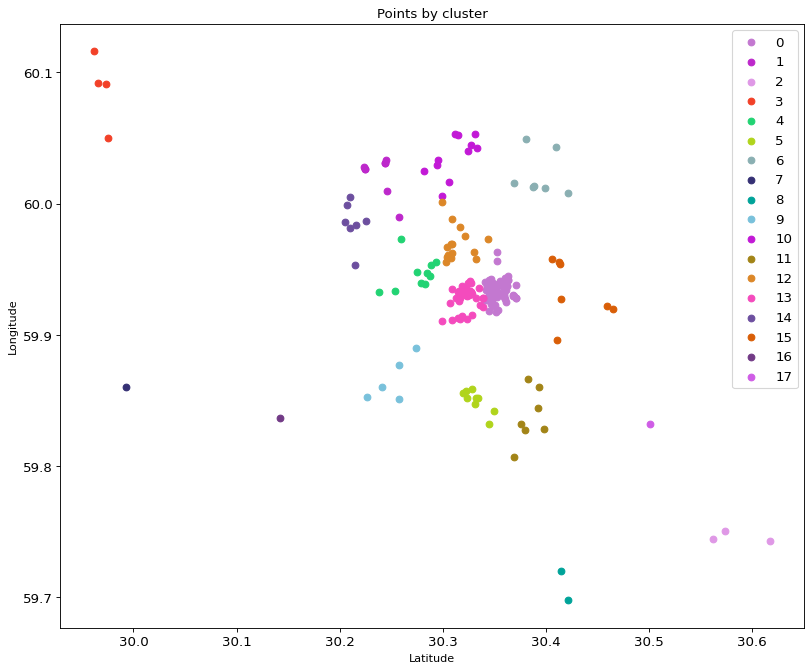

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Plot each class as a separate colour
n_clusters = 18 

plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
for n in range(n_clusters):
    # Filter data points to plot each in turn.
    ys = train['longitude'][ train['pickup cluster']==n ]
    xs = train['latitude'][ train['pickup cluster']==n ]

    plt.scatter(xs, ys, color=colors[n], label=str(n))

plt.gca().set(xlabel='Latitude', ylabel='Longitude')
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend(fontsize=12) 
plt.title("Points by cluster")

**P.S.** Если бы даже индексы терялись, поиск в базе данных можно осуществлять по имени заведения. Для алгоритма применяем базу данных содержащие только положение и название, т.к. при большом объеме данных и сложных вычислений - это бы сохранило RAM и GPU.


# Написание бота

In [11]:
!pip install python-telegram-bot --upgrade
!pip install selenium
!apt install chromium-chromedriver

     |████████████████████████████████| 378kB 6.3MB/s 
     |████████████████████████████████| 501kB 18.2MB/s 
     |████████████████████████████████| 2.7MB 21.3MB/s 
  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427642 sha256=cb83f6773feea4c42f57dea8c845b91404e9764ab95bb0eabda731be3c609528
  Stored in directory: /root/.cache/pip/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
Successfully built tornado
  Found existing installation: tornado 4.5.3
    Uninstalling tornado-4.5.3:
      Successfully uninstalled tornado-4.5.3


Первое, что нужно сделать это импортировать нашу библиотеку и подключить токен бота:

In [1]:
#Подключим библиотеки
import pandas as pd
import numpy as np
from selenium import webdriver
#Настройки
import logging
import os
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters
import telegram.ext
updater = Updater(token='Your_Key') # Токен API к Telegram
#Переменная для сортировки
num_bar = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TelegramDeprecationWarning: Old Handler API is deprecated - see https://git.io/fxJuV for details
  # Remove the CWD from sys.path while we load stuff.


Команды **Старт** и **Инструкция**.



In [2]:
# Обработка команд
def startCommand(bot, update):
    #Начало
    bot.send_message(chat_id=update.message.chat_id, text='Привет, давай пообщаемся?')

def helpMessage(bot, update):
    #Инструкция
    bot.send_message(chat_id=update.message.chat_id, text='Инструкция! Шаг 1. Поделись, пожалуйста, своим положением. Набери /location. Шаг 2. Узнай ближайшие бары. Набери /bar')

Взаимодействие с пользователем **Выбор бара** и **Прочие сообщения**.

In [3]:
def textMessage(bot, update):
    #Продублируем сообщение пользователя, если такого текста нет в коде.
    response = 'Получил Ваше сообщение: ' + update.message.text
    #Глобальная переменная для прокрутки списка
    global num_bar
    #Если "Нравится", тогда получаем ссылку
    if update.message.text == 'Нравится?':
      reply_markup = telegram.ReplyKeyboardRemove() #убирем клавиатуру
      response = 'Ссылка: ' + data.iloc[data.iloc[num_bar].name]['curl'] #ссылка
      bot.send_message(chat_id=update.message.chat_id, text=response, reply_markup=reply_markup)
    elif update.message.text == 'Следующий бар!' and num_bar != 10:
      #Картинка с веб-сайта должна загрузиться, для этого пишем сообщении об ожидании
      bot.send_message(chat_id=update.message.chat_id, text="Загружаю данные...")
      #Установим опции для хрома
      options = webdriver.ChromeOptions()
      options.add_argument('--headless')
      options.add_argument('--no-sandbox')
      options.add_argument('--disable-dev-shm-usage')
      #Получаем скриншот с экрана сайта tripadvisor раздела фото заведения
      wd = webdriver.Chrome('chromedriver',options=options)
      wd.get(data.iloc[data.iloc[num_bar].name]['curl']+"#photos")
      wd.save_screenshot('screenshot.png')
      #Генерируем сообщение 
      response = 'Ближайший бар: ' + train.iloc[num_bar][2] + ' Адрес: ' + data.iloc[data.iloc[num_bar].name]['address'] + ' Фото бара:'
      #Держим клавиатуру
      custom_keyboard = [['Нравится?', 'Следующий бар!']] 
      reply_markup = telegram.ReplyKeyboardMarkup(custom_keyboard)
      #Отправим сообщение
      bot.send_message(chat_id=update.message.chat_id, text=response, reply_markup=reply_markup)
      #Отправим скрин
      bot.send_photo(chat_id = update.message.chat_id, photo = open('/content/screenshot.png','rb')) 
      #Проверка, что индекс не больше 10,т.к. как у нас список из 10 баров, нужно начать листать заново.
      num_bar += 1
      if num_bar > 9:
        num_bar = 0
      
    else:
      #Обычное сообщение пользователя. Копируем его и показываем инструкцию
      bot.send_message(chat_id=update.message.chat_id, text=response)
      bot.send_message(chat_id=update.message.chat_id, text="Набери /help для инструкции")

Узнать местоположение пользователя

In [4]:
def getLocation(bot, update):
    #Пользователь должен подтвердить разрешение на использовании его местоположения
    location_keyboard = telegram.KeyboardButton(text='Определить местоположение', request_location=True)
    contact_keyboard = telegram.KeyboardButton(text='Нет, спасибо!')
    custom_keyboard = [[ location_keyboard, contact_keyboard ]]
    reply_markup = telegram.ReplyKeyboardMarkup(custom_keyboard)
    bot.send_message(chat_id=update.message.chat_id, text="Не могли бы вы поделиться своим местоположением и связаться со мной?", reply_markup=reply_markup)

In [5]:
def location(bot, update):
    #Получаем данные пользователя о его положении в глобальные переменные
    global user_longitude, user_latitude
    user_longitude = update.message.location.longitude
    user_latitude = update.message.location.latitude
    print(user_longitude,user_latitude)

Алгоритм поиска ближайших заведений.

In [6]:
def model(bot, update):
  #Импортируем основные данные о заведениях
  global data
  data = pd.read_csv('/content/data.csv')
  #Импортируем сокращенные данные о заведениях (положение и название)
  global train
  train = pd.read_csv('/content/data_coordinate.csv')
  #Дополнительно. Усложним алгоритм отбора заведений. Добавим данные place_in_rating - рейтинг заведения в категории, при этом если заведение не появлялось в рейтинге, тогда его рейтинг 1. Рейтинг стремится к 0, тем лучше заведение. P.S. Если искать только ближайшие заведения - эти строчки не нужно. Если цель алгоритма, будет рекомендовать сначало неизвестные заведения (которых нет в рейтинге), тогда убрать цикл замены 0 на 1.
  train['place_in_rating'] = data['place_in_rating']
  for i in range(len(train['place_in_rating'])):
    if train['place_in_rating'].iloc[i] == 0.000000:
      train['place_in_rating'].iloc[i] = 1.000000
    else:
      train['place_in_rating'].iloc[i] = train['place_in_rating'].iloc[i]
  #Разделим данные по кластерам. В нашем случае кластеров 18, т.к. регионов в Санк-Петербурге 18. Вычисляем косинусное расстояние (связи) 'cosine', критерий связи 'average'
  from sklearn.cluster import KMeans ,AgglomerativeClustering
  agc = AgglomerativeClustering(n_clusters =18, affinity='cosine', linkage='average')
  train['pickup cluster'] = agc.fit_predict(train[['longitude','latitude']])
  
  kmeans = KMeans(18)
  clusters = kmeans.fit_predict(train[['longitude','latitude']])
  train['pickup cluster'] = kmeans.predict(train[['longitude','latitude']])
  #Определим расстояние до пользователя. Радиус Земли взят средний в км.
  def haversine_distance(row):
    lat_p, lon_p = row['longitude'], row['latitude']
    lat_d, lon_d = user_latitude, user_longitude
    radius =  6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance
  #Колонка расстояние
  train['distance'] = train.apply(haversine_distance, axis = 1)
  #Возьмем 20 ближайших заведений
  train = train.sort_values(by='distance', ascending=True)[:20]
  #Сократим список до 10 самых рейтинговых заведений. Если захотим найти только ближайшие заведения. Удаляем нижнию строчку и вверхней строчке выставляем колличество 10 баров.
  train = train.sort_values(by='place_in_rating', ascending=True)[:10]
  #Сообщение для пользователя
  response = 'Процесс обработки завершен ... Готов узнать ближайший бар?'
  #Клавиатура
  custom_keyboard = [['Следующий бар!']]  
  reply_markup = telegram.ReplyKeyboardMarkup(custom_keyboard)
  bot.send_message(chat_id=update.message.chat_id, text=response, reply_markup = reply_markup)

Запуск среды (Телеграмм бот)

In [ ]:
#Получить диспетчер для регистрации обработчиков
dp = updater.dispatcher

# Добавляем хендлеры в диспетчер
#На разные команды - ответьте в Telegram
dp.add_handler(CommandHandler("start", startCommand))
dp.add_handler(CommandHandler("help", helpMessage))
dp.add_handler(CommandHandler("location", getLocation))
dp.add_handler(CommandHandler("bar", model))

#На некомандном, т.е. сообщение - отобразить сообщение на Telegram
dp.add_handler(MessageHandler(Filters.text, textMessage))
dp.add_handler(MessageHandler(Filters.location, location))

#dp.add_handler(MessageHandler(Filters.regex, method)) #на случай организации меню
#Старт для бота
updater.start_polling()

#start_polling () неблокирует и корректно остановит бота.
updater.idle()

30.329664 59.847994


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
